## Analyzing refractive index of vinyl chloride in water
___
**Philip J**\
**Date Updated: 31-10-20223**

### Setup

**Libraries**


In [26]:
import matplotlib.pyplot as plt     # For plots
import numpy as np                  # Numpy for working with numbers
import pyspectroworks               # API interface with Spectroworks
from datetime import datetime       # For handling dates and times.
import re                           # Regular expressions
import pyperclip

Connecting to the pyspectroworks api

In [27]:
api_key = "ZWZhMWQ1MTQtOGM4MS00YzI1LWJiY2UtNTg3YWY1MGI5ZmQ0"
ALL_PROJECTS_KEY = "ODE2NmRhZTctM2IwMC00YzAwLTllYzgtOWIyM2E3NjczYjU4"
conn = pyspectroworks.connect(api_key)

Accessing the information about the project.

In [28]:
projects = conn.get_projects()      # Loading all the projects

project = projects[0]               # This is the main project.
print(projects)
items = project.get_items()

Getting the Test number *(T#)* and the Time value from the Sample name

In [29]:
def get_test_number(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return

    test_number = re.findall(r'T\d+', sample_name)
    if test_number:
        return int(test_number[0][1:])
    else:
        return 'N/A'

def get_pbs_number(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return
    
    pbs_number = re.findall(r'PBS \d+%', sample_name)
    if pbs_number:
        return int(pbs_number[0][4:-1])
    else:
        return 'N/A'
    

def get_measurement_time(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return
    
    measurement_time = re.findall(r'\d+\.?\d*min', sample_name)
    if measurement_time:
        return float(measurement_time[0][:-3])
    else:
        return 'N/A'
    
def is_water_reference(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return
    
    water_reference = True if re.findall(r'water reference', sample_name.lower()) else False 
    return water_reference

Looking at the data in the items.

In [30]:
print('{: >6} {:>32} {: >24}'.format('Index', 'Name', 'Created'))
for i, item in enumerate(items):
    try:
        sample_name = item.sample_attributes['Sample name']
    except KeyError:
        sample_name = "N/A"

    timestamp = datetime.utcfromtimestamp(item.created).strftime('%d-%m-%Y %H:%M:%S')
    # print('{: >6} {: >32} {: >24}'.format(i, sample_name, timestamp))

 Index                             Name                  Created


### Plotting the standard spectra

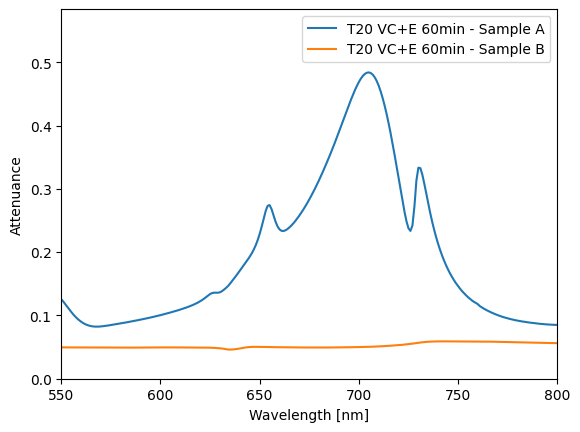

In [31]:
try:                                                                        # Trying to get the sample name, if it is empty put N/A
    sample_name = item.sample_attributes['Sample name']
except KeyError:
    sample_name = "N/A"

sample_spectrum = np.array(item.get_spectrum('sample_B'))
plt.plot(sample_spectrum[:, 0], sample_spectrum[:, 1], label=f"{sample_name} - Sample A")   # Plotting the spectrum
y_max = max(sample_spectrum[:, 1])

sample_spectrum = np.array(item.get_spectrum('sample_A'))
plt.plot(sample_spectrum[:, 0], sample_spectrum[:, 1], label=f"{sample_name} - Sample B")   # Plotting the spectrum

plt.xlim([min(sample_spectrum[:,0]), 800])
plt.ylim(0.0, y_max+0.1)
# plt.ylim(0.0, 4.0)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Attenuance')
plt.show()

Combining the refractive index values for the different tests *(T#)*

In [32]:
analyze_test_number = 16
# analyze_range = range(9, 12)

refractive_index = [[]]
time = []
fit_quality = []
for i, item in enumerate(items):
    try:
        sample_name = item.sample_attributes['Sample name']
    except KeyError:
        sample_name = 'N/A'

    if get_test_number(item) == analyze_test_number and not is_water_reference(item):
    # if get_pbs_number(item) == analyze_test_number and not is_water_reference(item): 
        refractive_index.append((item.results.get('refractive_index', {})).get('value', 'N/A'))
        time.append((get_measurement_time(item)))
        try:
            analyte = item.sample_attributes['Analyte']
        except KeyError:
            analyte = ""
        solvent = item.sample_attributes['Solvent']
        fit_quality.append(item.results.get('sample_fit_quality', {}).get('value', 'N/A'))
    

refractive_index = refractive_index[1:]
ri_std_deviation = np.std(refractive_index)
ri_std_deviation_latter_half = np.std(refractive_index[len(refractive_index)//2:])
ri_mean = np.mean(refractive_index)
ri_no_outliers = []
time_no_outliers = []

for i, ri in enumerate(refractive_index):
    if ri > ri_mean + 2*ri_std_deviation or ri < ri_mean - 2*ri_std_deviation:
        continue
    else:
        ri_no_outliers.append(ri)
        time_no_outliers.append(time[i])

std_no_outliers = np.std(ri_no_outliers)
std_no_outliers_last_30_minutes = np.std(ri_no_outliers[len(ri_no_outliers)//2:])


Averaging out the data from `ri_no_outliers`.

In [33]:
average_window_size = 3

ri_moving_average = []

i = 0
while i < len(ri_no_outliers) - average_window_size + 1:

    window = ri_no_outliers[i : i + average_window_size]

    window_average = sum(window) / average_window_size
    # print(window_average)

    ri_moving_average.append(window_average)

    i += 1


Getting the RI shift over a range of measurements

Getting the different properties of the measurement from the data\
All the information is written in the *sample attributes*, and then I am using regular expressions to get those values.

In [34]:
vc_volume = re.findall(r'\d+\.*\d*ul', analyte) # ul
vc_volume = float(vc_volume[0][:-2]) if len(vc_volume) > 0 else 0
di_volume = float(re.findall(r'\d+\.*\d*ml',solvent)[0][:-2]) # ml
try:
    enzyme_weight = float(re.findall(r'Enzyme \d+\.*\d*ug', analyte)[0][7:-2])
except IndexError:
    enzyme_weight = 0

vc_source_concentration = 2000 # ug/ml in methanol -> 2ug/ul

vc_concentration = (vc_volume*vc_source_concentration/1000)/di_volume # ug/ml

Plotting the refractive index against time

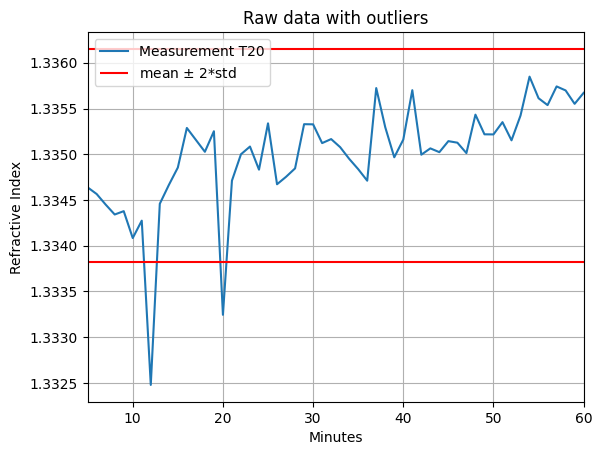

In [35]:
fig, ax = plt.subplots()

ax.plot(time, refractive_index, label=f"Measurement T{analyze_test_number}")
ax.hlines(y=ri_mean+2*ri_std_deviation, xmin=min(time), xmax=max(time), color='r', label=r"mean $\pm$ 2*std")
ax.hlines(y=ri_mean-2*ri_std_deviation, xmin=min(time), xmax=max(time), color='r')

plt.legend()
plt.grid(True)
plt.xlim(min(time), max(time))
plt.title("Raw data with outliers")
plt.xlabel("Minutes")
plt.ylabel("Refractive Index")

plt.show()

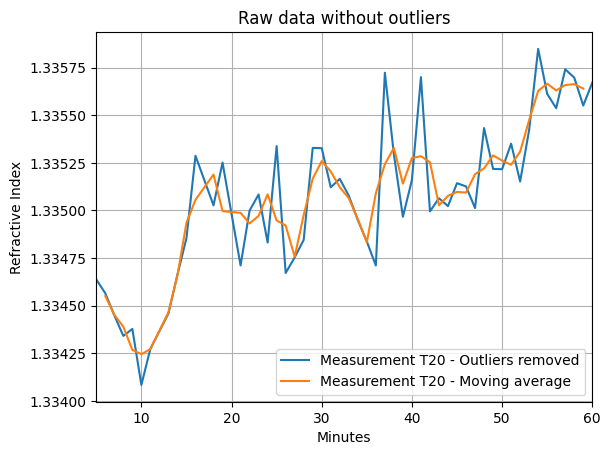

In [36]:
fig, ax = plt.subplots()

ax.plot(time_no_outliers, ri_no_outliers, label=f"Measurement T{analyze_test_number} - Outliers removed")
ax.plot(time_no_outliers[1:-1], ri_moving_average, label=f"Measurement T{analyze_test_number} - Moving average")

plt.legend()
plt.grid(True)
plt.xlim(min(time), max(time))
# plt.ylim(1.335,1.341)
plt.title("Raw data without outliers")
plt.xlabel("Minutes")
plt.ylabel("Refractive Index")

plt.show()

The RI shift and properties of the measurement

In [38]:
ri_shift = max(ri_no_outliers) - ri_no_outliers[0]

output_string = f'''
**Properties**

| Property | Value |
| ---------- | ----- |
| Test number |T{analyze_test_number} |
| Vinyl Chloride volume | {vc_volume} $\mu l$ |
| Enzyme weight | {enzyme_weight} $\mu g$ |
| DI water volume | {di_volume} ml |
| VC Concentration | {(float(vc_volume)*2)/float(di_volume)} $\mu g / ml$ |

**Results**

| Property | Value |
| -------- | ----- |
| RI Shift (*outliers removed*)|{ri_shift}|
| RI Shift (*moving average*) |{max(ri_moving_average) - ri_moving_average[0]}|
| Average fit quality | {np.average(fit_quality):.2f}% |
| Average RI | {np.average(ri_no_outliers):.6f} |
| Average RI (last half) | {np.average(ri_no_outliers[len(ri_no_outliers)//2:]):.6f} |

**Standard deviation**

| Standard deviation | Value |
| ------------------ | ----- |
| $\sigma$ $\\times 10^3$ | {ri_std_deviation*1000:.4f} |
| $\sigma$ *(last 30 minutes)* $\\times 10^3$ | {ri_std_deviation_latter_half*1000:.4f} |
| $\sigma$ *(Without outliers)* $\\times 10^3$ | {std_no_outliers*1000:.4f} |
| $\sigma$ *(Without outliers, last 30 minutes)* $\\times 10^3$ | {std_no_outliers_last_30_minutes*1000:.4f} |

'''
# output_string = f'''
# **Properties**

# | Property | Value |
# | ---------- | ----- |
# | PBS Concentration |{analyze_test_number}% |
# | PBS volume | {vc_volume} ul |
# | DI water volume | {di_volume} ml |

# **Results**

# | Property | Value |
# | -------- | ----- |
# | RI Shift (*outliers removed*)|{ri_shift}|
# | RI Shift (*moving average*) |{max(ri_moving_average) - ri_moving_average[0]}|
# | Average fit quality | {np.average(fit_quality):.2f}% |
# | Average RI | {np.average(ri_no_outliers):.6f} |
# | Average RI (last half) | {np.average(ri_no_outliers[len(ri_no_outliers)//2:]):.6f} |

# **Standard deviation**

# | Standard deviation | Value |
# | ------------------ | ----- |
# | $\sigma$ $\\times 10^3$ | {ri_std_deviation*1000:.4f} |
# | $\sigma$ *(last 30 minutes)* $\\times 10^3$ | {ri_std_deviation_latter_half*1000:.4f} |
# | $\sigma$ *(Without outliers)* $\\times 10^3$ | {std_no_outliers*1000:.4f} |
# | $\sigma$ *(Without outliers, last 30 minutes)* $\\times 10^3$ | {std_no_outliers_last_30_minutes*1000:.4f} |

# '''

print("--- Markdown format ---")
print(output_string)
print("--- String copied ---")
pyperclip.copy(output_string)

--- Markdown format ---

**Properties**

| Property | Value |
| ---------- | ----- |
| Test number |T20 |
| Vinyl Chloride volume | 10.0 $\mu l$ |
| Enzyme weight | 1.36 $\mu g$ |
| DI water volume | 10.0 ml |
| VC Concentration | 2.0 $\mu g / ml$ |

**Results**

| Property | Value |
| -------- | ----- |
| RI Shift (*outliers removed*)|0.0012106055106768654|
| RI Shift (*moving average*) |0.0011151908663364907|
| Average fit quality | 87.74% |
| Average RI | 1.335070 |
| Average RI (last half) | 1.335302 |

**Standard deviation**

| Standard deviation | Value |
| ------------------ | ----- |
| $\sigma$ $\times 10^3$ | 0.5811 |
| $\sigma$ *(last 30 minutes)* $\times 10^3$ | 0.3073 |
| $\sigma$ *(Without outliers)* $\times 10^3$ | 0.4093 |
| $\sigma$ *(Without outliers, last 30 minutes)* $\times 10^3$ | 0.3101 |


--- String copied ---
